<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

from random import randint
from urllib.request import urlopen

from numpy import asarray

train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)


total_images = df.thumbnail_url.notna().sum()
# total_images

df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN


# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]
# labels[:5]


# Count the apperence of label
all_label = [label for sub in labels for label in sub]
labels_count = Counter(all_label)
# labels_count

labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}
inv_label_map

{0: 'top_t-shirt_sweatshirt',
 1: 'pants',
 2: 'shoe',
 3: 'dress',
 4: 'skirt',
 5: 'shirt_blouse',
 6: 'shorts',
 7: 'watch',
 8: 'bag_wallet',
 9: 'jacket',
 10: 'belt',
 11: 'nan',
 12: 'hat',
 13: 'coat',
 14: 'glasses',
 15: 'sweater',
 16: 'headband_head-covering_hair-accessory',
 17: 'cardigan',
 18: 'jumpsuit',
 19: 'scarf',
 20: 'vest'}

# Model

In [1]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [3]:
in_shape = (280,280,3)
out_shape = 21

In [4]:
model = EfficientNetB3(include_top=False,
                       input_shape = in_shape)
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer="he_uniform")(flat1)
output = Dense(out_shape, activation="sigmoid")(class1)

model = Model(inputs=model.inputs, outputs=output)
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

43950080/43941136 [==============================] - 1s 0us/step


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 280, 280, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 280, 280, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 281, 281, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [6]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
datagen = ImageDataGenerator()
# datagen.mean = [123.68, 116.778, 103.939]
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [9]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=30)

Epoch 1/30
50/50 [==============================] - 103s 1s/step - loss: 0.2425 - fbeta: 0.5264 - val_loss: 0.1756 - val_fbeta: 0.6188
Epoch 2/30
50/50 [==============================] - 53s 1s/step - loss: 0.1254 - fbeta: 0.7167 - val_loss: 0.1681 - val_fbeta: 0.6261
Epoch 3/30
50/50 [==============================] - 53s 1s/step - loss: 0.0924 - fbeta: 0.7967 - val_loss: 0.1625 - val_fbeta: 0.6361
Epoch 4/30
50/50 [==============================] - 53s 1s/step - loss: 0.0710 - fbeta: 0.8558 - val_loss: 0.1638 - val_fbeta: 0.6480
Epoch 5/30
50/50 [==============================] - 53s 1s/step - loss: 0.0558 - fbeta: 0.8856 - val_loss: 0.1665 - val_fbeta: 0.6539
Epoch 6/30
50/50 [==============================] - 53s 1s/step - loss: 0.0455 - fbeta: 0.9254 - val_loss: 0.1672 - val_fbeta: 0.6529
Epoch 7/30
50/50 [==============================] - 53s 1s/step - loss: 0.0376 - fbeta: 0.9442 - val_loss: 0.1718 - val_fbeta: 0.6520
Epoch 8/30
50/50 [==============================] - 53s 1s/st

In [10]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_EfficientNetB3/model_EfficientNetB3')

In [ ]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")


In [13]:
predictions = model.predict(test_data)



def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags


prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]

prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

In [14]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

submission["cloth_type"] = submission.cloth_type.str.replace("nan","")
submission[50:70]

,id,cloth_type
50,4755,jacket
51,4756,
52,4757,top_t-shirt_sweatshirt shoe skirt
53,4758,top_t-shirt_sweatshirt pants shoe
54,4759,pants shoe shirt_blouse
55,4760,
56,4761,pants
57,4762,shoe dress bag_wallet
58,4763,pants
59,4764,top_t-shirt_sweatshirt shirt_blouse watch


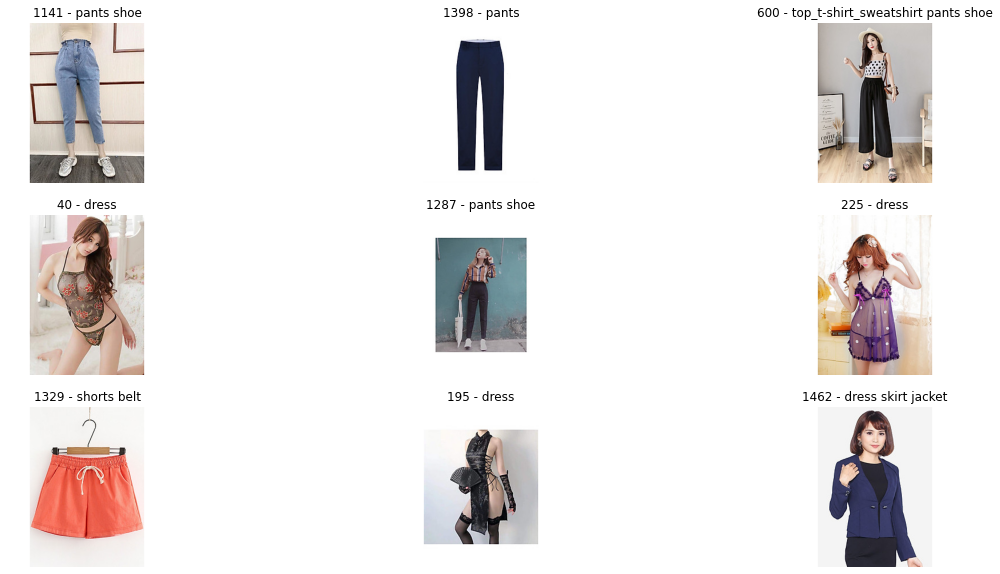

In [17]:
# plot random 9 image
fig = plt.figure(figsize=(20,10))
for i in range(0,9):
  ax = plt.subplot(3,3,i+1)
  _i = randint(0,len(test_data))
  ax = plt.imshow(test_data[_i])
  plt.title(f"{_i} - {prediction_tags[_i]}")
  plt.axis("off")

In [16]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v5_EfficientNetB3_21.csv', index=False)